In [ ]:
# Realtime fastest - Jothi Only code

In [513]:
%matplotlib inline

import os
import numpy as np
import cv2
import copy
import math as mt
from math import sin, cos, radians, pi
from scipy.signal import find_peaks
from sympy import Point, Line, Symbol, pi
from skimage import draw
import matplotlib.pyplot as plt
import time
import math
from statistics import mode
import pandas as pd
from natsort import natsorted

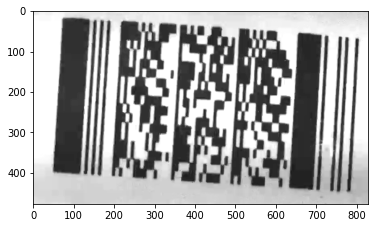

In [514]:
# INPUT_IMAGE_PATH = '/media/Work/Codes/Private/pdf417-decoder/output/images/'\
#                    'Crop/15-02-2021/17:00:00/15-02-2021_17:42:57:272_009/00031_1.bmp'

# INPUT_IMAGE_PATH = '/media/Work/Codes/Private/pdf417-decoder/output/images/Crop/15-02-2021/17:00:00/15-02-2021_17:39:06:079_001/00006_1.bmp'
INPUT_PATH = '/home/sandana/Documents/good_crops'
image_files = natsorted(os.listdir(INPUT_PATH))

INPUT_IMAGE_PATH = os.path.join(INPUT_PATH, image_files[10])
input_image = cv2.imread(INPUT_IMAGE_PATH, 0)
plt.imshow(input_image, cmap='gray')

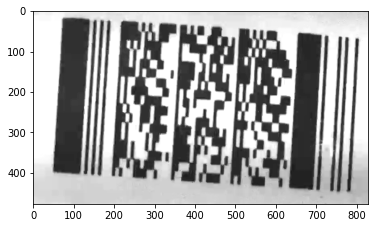

In [515]:
def convert_image(var_image):
    d = np.ndim(var_image)
    
    if d == 3:
        var_gray_img = cv2.cvtColor(var_image, cv2.COLOR_BGR2GRAY)
    else:
        var_gray_img = var_image
    
    return var_gray_img

converted_image = convert_image(input_image)
plt.imshow(converted_image, cmap='gray')

In [516]:
def all_corners(var_gray_img, threshold=0.3):

    corners = cv2.goodFeaturesToTrack(var_gray_img, 1000, threshold, 10)
    var_all_corners = np.array(tuple(map(np.ravel, corners)), dtype=np.int0)
    
    return var_all_corners

var_all_corners = all_corners(converted_image)
var_all_corners.shape

(169, 2)

In [517]:
def image_corners(var_gray_img):
    '''Find corner indices of the Image'''

    row, col = var_gray_img.shape
    img_area = row * col
    var_image_corners = [[0, 0],
                          [col - 1, 0],
                          [col - 1, row - 1],
                          [0, row - 1]]

    return var_image_corners

var_image_corners = image_corners(converted_image)
var_image_corners

[[0, 0], [827, 0], [827, 476], [0, 476]]

In [518]:
def min_dist(point, points_array):
    '''Find the min distance between reference points with the points'''
    
    x1, y1 = point
    dist_arr = []
    for i in range(len(points_array)):
        x2, y2 = points_array[i]
        d = mt.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
        dist_arr.append(d)

    return min(dist_arr), np.argmin(dist_arr)


def distances(var_all_corners, var_image_corners):
    '''Find the distances of corners of the Barcode'''
    
    var_distances = [min_dist(point, var_all_corners) for point in var_image_corners]
    
    return var_distances


var_distances = distances(var_all_corners, var_image_corners)
var_distances

[(170.69563556224864, 140),
 (75.39230729988306, 101),
 (98.08159868191383, 156),
 (152.6892268629323, 12)]

In [519]:
def order_points(points):
    rect = np.zeros((4, 2), dtype="float32")

    s = points.sum(axis=1)
    rect[0] = points[np.argmin(s)]
    rect[2] = points[np.argmax(s)]

    diff = np.diff(points, axis=1)
    rect[1] = points[np.argmin(diff)]
    rect[3] = points[np.argmax(diff)]

    return rect

In [520]:
def barcode_corners(var_all_corners, var_distances):
    '''Get Barcode corner co-ordinates'''

    var_barcode_corners = order_points(np.array([var_all_corners[
                                                               var_distances[i][1]]
                                                           for i in range(4)]))
    return var_barcode_corners

var_barcode_corners = barcode_corners(var_all_corners, var_distances)
var_barcode_corners

array([[169.,  24.],
       [799.,  70.],
       [735., 442.],
       [133., 401.]], dtype=float32)

In [521]:
def find_top_border_angle(var_barcode_corners):
    '''Find Angle of Top border'''
    
    P1 = var_barcode_corners[0][:]
    P2 = var_barcode_corners[1][:]

    top_line_angle = 90 - round(math.degrees(math.atan2((round(P1[0], 2) - 
                                                         round(P2[0], 2)), 
                                                        (round(P1[1], 2) - 
                                                         round(P2[1], 2)))))

    return top_line_angle

top_line_angle = find_top_border_angle(var_barcode_corners)
top_line_angle

184

In [522]:
def point_angles(var_barcode_corners):
    '''Get Barcode corner co-ordinates'''
    
    points = list(map(Point, var_barcode_corners))

    var_angle_arr = []
    for i in range(len(points)):
        l1 = Line(points[i], points[i - 1])
        try:
            l2 = Line(points[i], points[i + 1])
        except:
            l2 = Line(points[i], points[-len(points)])

        angle = l1.angle_between(l2)
        var_angle_arr.append(float(angle * (180 / pi)))
    
    return var_angle_arr

var_angle_arr = point_angles(var_barcode_corners)
var_angle_arr

[91.27858517052226, 84.41431575256232, 95.86558720525103, 88.44151187166439]

In [523]:
def associated_pts(var_angle_arr):

    var_associat_pts = []
    angle_variance = []
    angle_diff = []
    for i in range(len(var_angle_arr)):
        if i:
            angles = [var_angle_arr[i], var_angle_arr[i - 1]]
            var_associat_pts.append([i, angles])
        else:
            angles = [var_angle_arr[i], var_angle_arr[-1]]
            var_associat_pts.append([i, angles])
        angle_variance.append([i, np.var(angles)])
        angle_diff.append
        
    return var_associat_pts, angle_variance

var_associat_pts, angle_variance = associated_pts(var_angle_arr)
print(f'var_associat_pts: {var_associat_pts}')
print(f'angle_variance: {angle_variance}')

var_associat_pts: [[0, [91.27858517052226, 88.44151187166439]], [1, [84.41431575256232, 91.27858517052226]], [2, [95.86558720525103, 84.41431575256232]], [3, [88.44151187166439, 95.86558720525103]]]
angle_variance: [[0, 2.012246225773074], [1, 11.779548660585045], [2, 32.78290447079088], [3, 13.779223639692406]]


In [524]:
def vert_dist(var_barcode_corners, var_all_corners):

    p1, p2 = var_barcode_corners[:2]
    ppcular_dist = []
    for i in range(len(var_all_corners)):
        p3 = var_all_corners[i]
        d = abs(np.cross(p2 - p1, p3 - p1) / np.linalg.norm(p2 - p1))
        ppcular_dist.append(d)
    var_vert_dist = np.array(ppcular_dist)
    
    return var_vert_dist

var_vert_dist = vert_dist(var_barcode_corners, var_all_corners)
var_vert_dist.shape

(169,)

In [525]:
def sorted_distances(var_vert_dist):
    var_sorted_dist = np.sort(var_vert_dist)
    
    return var_sorted_dist

def distance_gradients(var_sorted_dist):
    var_dist_grad = np.gradient(var_sorted_dist)
    
    return var_dist_grad

def highest_peak(distance_gradients):
    var_highest_peak = np.max(distance_gradients)
    
    return var_highest_peak

def get_peaks(var_dist_grad, var_sorted_dist, var_highest_peak, height=0.5):

    peak_indices, peaks = find_peaks(var_dist_grad, height=height * var_highest_peak)
    peak_indices = np.append(peak_indices, len(var_sorted_dist))

    var_peak_indices, var_peaks = peak_indices, peaks['peak_heights']
    
    return var_peak_indices, var_peaks

var_sorted_dist = sorted_distances(var_vert_dist)
var_dist_grad = distance_gradients(var_sorted_dist)
var_highest_peak = highest_peak(var_dist_grad)

var_peak_indices, var_peaks = get_peaks(var_dist_grad, var_sorted_dist, var_highest_peak, height=0.7)
var_peak_indices

array([ 22,  34,  46,  56,  64,  78,  85,  96, 107, 117, 128, 135, 144,
       153, 158, 163, 169])

In [526]:
def search_threshold(converted_image, in_threshold_arr=[0.25, 0.3, 0.35]):
    variance_data_arr = []
    peaks_data_arr = []
    out_threshold_arr = []
    
    present_flag = False

    for threshold in in_threshold_arr:

        try:
            # print(threshold_arr)
            print(threshold)
            var_all_corners = all_corners(converted_image, threshold=threshold)
            var_image_corners = image_corners(converted_image)
            var_distances = distances(var_all_corners, var_image_corners)
            var_barcode_corners = barcode_corners(var_all_corners, var_distances)
            top_line_angle = find_top_border_angle(var_barcode_corners)
            var_angle_arr = point_angles(var_barcode_corners)
            var_associat_pts, angle_variance = associated_pts(var_angle_arr)
            var_vert_dist = vert_dist(var_barcode_corners, var_all_corners)
            print(1)
            
            
            var_sorted_dist = sorted_distances(var_vert_dist)
            var_dist_grad = distance_gradients(var_sorted_dist)
            var_highest_peak = highest_peak(var_dist_grad)
            
            peak_indices, peaks = get_peaks(var_dist_grad, var_sorted_dist, var_highest_peak, height=0.4)
            print(2)
            variance_data = [np.var(peaks), np.var(np.gradient(peak_indices[:-1]))]
            print(f'peaks: {peak_indices}')
            print(f'len(peaks): {len(peaks)}')
            print(f'peaks_diff: {np.diff(np.array(sorted(peaks)))}')
            peaks_data_arr.append(peaks)
            variance_data_arr.append(variance_data)
            out_threshold_arr.append(threshold)
            present_flag = True
            
        except:
            pass

    if present_flag:
        variance_data_arr = np.transpose(variance_data_arr)
        peaks_data_arr = peaks_data_arr

    else:
        variance_data_arr = np.array([])
        peaks_data_arr = np.array([])
    
    return out_threshold_arr, peaks_data_arr, variance_data_arr

start = time.time()
threshold_arr, peaks_data_arr, variance_data_arr = search_threshold(converted_image)
print(f'Time Duration: {time.time() - start}')

print(f'threshold_arr: {threshold_arr}')
print(f'peaks_data_arr: {peaks_data_arr}')
print(f'variance_data_arr: {variance_data_arr}')

0.25
1
2
peaks: [ 17  27  45  61  75  86 100 115 129 143 158 174 182 194 205 215 223 231]
len(peaks): 17
peaks_diff: [2.28122872 0.29287114 0.27545718 0.01424779 0.25962631 0.13772859
 0.20738443 0.04590953 0.10131758 0.07598819 0.02849557 0.08232054
 0.17097342 0.05540805 0.22479839 0.2485447 ]
0.3
1
2
peaks: [ 10  22  34  46  56  64  78  85  96 107 117 128 135 144 153 158 163 169]
len(peaks): 17
peaks_diff: [2.47594846 0.3846902  0.09815141 0.1741396  0.46067839 0.02691248
 0.16464107 0.03799409 0.10764993 0.13931168 0.14564403 0.02374631
 0.00791544 0.17097342 0.23746309 0.5208357 ]
0.35
1
2
peaks: [ 27  34  39  41  46  58  63  69  80  90  98 108 111 114 117 121 124 127]
len(peaks): 17
peaks_diff: [0.44641719 0.1999949  0.23927961 0.21785159 0.26427897 0.24999362
 0.50712992 0.43570317 0.08214076 0.48213056 0.17856687 0.49998725
 0.18213821 0.40713247 0.17499554 0.38213311]
Time Duration: 0.11599016189575195
threshold_arr: [0.25, 0.3, 0.35]
peaks_data_arr: [array([4.88540725, 9.3877

In [527]:
def optim_threshold(threshold_arr, peaks_data, variance_data):

    save_var = {'variance': variance_data, 'peaks': peaks_data}
    
    good_heights = []
    if len(peaks_data):
        print(f'[max(peak) for peak in peaks_data]: {[max(peak) for peak in peaks_data]}')
        max_peak_list = [max(peak) for peak in peaks_data]
        
        sizes = []
        for max_peak, peaks_list in zip(max_peak_list, peaks_data):
            cap = 0.5 * max_peak

            print(f'max_peak: {max_peak}')
            print(f'peaks_list: {peaks_list}')
            mask = peaks_list  >= cap
            size = len(peaks_list)
            sizes.append(size)
        
            print(f'mask: {mask}')
            print(f'size: {size}')

            good_height = np.count_nonzero(mask) == size
            print(f'good_height: {good_height}')
            
            good_heights.append(good_height)

        order = variance_data.argsort()
        ranks = order.argsort()
        total_variance = np.var(ranks, axis=0)
        weighted_ranks = np.sum(ranks, axis=0)
        cum_ranks = np.sum([total_variance, weighted_ranks], axis=0)
        print(f'variance_data: {variance_data}')
        print(f'total_variance: {total_variance}')
        print(f'cum_ranks: {cum_ranks}')
        
        index = np.argmin(cum_ranks)
        
        print(f'good_heights: {good_heights}')
        print(f'index: {index}')
        index = sizes.index(max(sizes))

        if good_heights[index]:
            var_optim_threshold = threshold_arr[index]
            return var_optim_threshold
        else:
            return None
    
    return None

start = time.time()
var_optim_threshold = optim_threshold(threshold_arr, peaks_data_arr, variance_data_arr)
print(f'Time taken: {time.time() - start}')
print(f'var_optim_threshold: {var_optim_threshold}')

[max(peak) for peak in peaks_data]: [9.387707381627415, 10.160253958732682, 8.321216347326498]
max_peak: 9.387707381627415
peaks_list: [4.88540725 9.38770738 7.73496429 7.16663597 8.35395141 8.91436429
 8.68798282 8.39986094 8.50117852 8.00883839 7.74921208 8.60566228
 8.57716671 7.45950711 9.13916268 8.14656698 8.85895624]
mask: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True]
size: 17
good_height: True
max_peak: 10.160253958732682
peaks_list: [ 4.98355866  9.40195517  7.94234872  7.84419731  8.76872027  8.91436429
  8.80671436  9.05367597  9.19932     8.11648832  8.60407919  9.22306631
  8.57716671  7.45950711 10.16025396  9.23098174  9.63941825]
mask: [False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True]
size: 17
good_height: False
max_peak: 8.321216347326498
peaks_list: [4.47488587 4.01775467 4.73916485 4.25703429 6.67482977 4.98915847
 7.7640877  3.37134259 3.81775977 6.49626

In [528]:
def class_centers(var_peak_indices):
    '''To calculate centroids by averaging distance measures between peaks'''

    centroids = []
    for i in range(len(var_peak_indices)):
        if i == 0:
            min_idx = 0
            max_idx = var_peak_indices[i]
        elif i == len(var_peak_indices) - 1:
            min_idx = var_peak_indices[i - 1]
            max_idx = len(var_sorted_dist)
        else:
            min_idx = var_peak_indices[i - 1]
            max_idx = var_peak_indices[i]

        centroids.append(np.mean(var_sorted_dist[min_idx: max_idx]))

    return centroids


var_all_corners = all_corners(converted_image, threshold=var_optim_threshold)
# var_all_corners = all_corners(converted_image, threshold=0.25)
var_image_corners = image_corners(converted_image)
var_distances = distances(var_all_corners, var_image_corners)
var_barcode_corners = barcode_corners(var_all_corners, var_distances)
top_line_angle = find_top_border_angle(var_barcode_corners)
var_angle_arr = point_angles(var_barcode_corners)
var_associat_pts, angle_variance = associated_pts(var_angle_arr)
var_vert_dist = vert_dist(var_barcode_corners, var_all_corners)

var_sorted_dist = sorted_distances(var_vert_dist)
var_dist_grad = distance_gradients(var_sorted_dist)
var_highest_peak = highest_peak(var_dist_grad)

var_peak_indices, var_peaks = get_peaks(var_dist_grad, var_sorted_dist, var_highest_peak, height=0.51)
centroids = class_centers(var_peak_indices)
diff = np.diff(np.array(centroids)).tolist()
centroids

[2.5903032291176284,
 15.985065179636536,
 38.1807223526968,
 62.914063987103404,
 84.20893383640008,
 106.90588186868455,
 130.809368539393,
 152.31621188659153,
 174.6638253327805,
 196.48148147636908,
 219.6879725242634,
 244.1350084323745,
 265.73662970541864,
 287.4432624325911,
 310.36483067113494,
 332.8092660075494,
 357.0467275487907,
 378.57275640573494]

In [529]:
def labels(var_vert_dist, var_sorted_dist, var_peak_indices):
    '''To get the labels of the co-ordinates with centroids as reference'''

    labels = copy.deepcopy(var_vert_dist)
    for i in range(len(var_peak_indices)):
        if i == 0:
            min_idx = 0
            max_idx = var_peak_indices[i]
        elif i == len(var_peak_indices) - 1:
            min_idx = var_peak_indices[i - 1]
            max_idx = len(var_sorted_dist) - 1
        else:
            min_idx = var_peak_indices[i - 1]
            max_idx = var_peak_indices[i]

        if i != len(var_peak_indices) - 1:
            labels[np.where((var_vert_dist < var_sorted_dist[max_idx]) &
                            (var_vert_dist >= var_sorted_dist[min_idx]))] = i
        else:
            labels[np.where((var_vert_dist <= var_sorted_dist[max_idx]) &
                            (var_vert_dist >= var_sorted_dist[min_idx]))] = i

    var_labels = labels.astype(int)
    
    return var_labels

var_labels = labels(var_vert_dist, var_sorted_dist, var_peak_indices)

var_labels1 = pd.Series(var_labels)
list(var_labels1.groupby(var_labels1).count())
np.var(var_labels1)

24.635445362718094

In [530]:
def center_coordinates(var_labels):
    '''Find the centroid of the coordinates'''

    var_center_coord = []
    concur_feat_sep = []
    coords = var_all_corners
    
    for i in range(len(np.unique(var_labels))):
        selected_bin = coords[np.where(var_labels == i)]
        centroid = np.mean(selected_bin, axis=0)
        var_center_coord.append(centroid)
        concur_feat_sep.append(centroid.astype('int'))
    
    return var_center_coord, concur_feat_sep


var_center_coord, int_var_center_coord = center_coordinates(var_labels)

print(f'\nvar_center_coord: {var_center_coord}\n')
print(f'\int_var_center_coord: {int_var_center_coord}\n')


var_center_coord: [array([521.        ,  47.17647059]), array([426.1,  58.8]), array([461.11111111,  83.61111111]), array([449.5   , 107.5625]), array([445.78571429, 128.64285714]), array([425.36363636, 149.90909091]), array([387.92857143, 171.14285714]), array([440.33333333, 196.53333333]), array([483.21428571, 222.07142857]), array([400.78571429, 237.92857143]), array([429.13333333, 263.26666667]), array([453.5625, 289.5625]), array([457.375, 311.5  ]), array([412.66666667, 330.        ]), array([486.36363636, 358.36363636]), array([374.5, 372.7]), array([367.625, 396.5  ]), array([315.125, 414.25 ])]

\int_var_center_coord: [array([521,  47]), array([426,  58]), array([461,  83]), array([449, 107]), array([445, 128]), array([425, 149]), array([387, 171]), array([440, 196]), array([483, 222]), array([400, 237]), array([429, 263]), array([453, 289]), array([457, 311]), array([412, 330]), array([486, 358]), array([374, 372]), array([367, 396]), array([315, 414])]



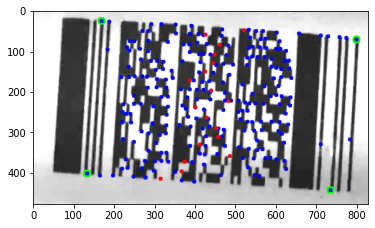

In [532]:
def overlay_corners(image, corners, radius, color, inplace=False):
    if not inplace:
        overlaid_image = copy.deepcopy(image)
    else:
        overlaid_image = image

    corners = tuple(map(tuple, corners))
    for corner in corners:
        cv2.circle(overlaid_image, corner, radius, color, -1)
    return overlaid_image


def overlay_lines(image, start, end, line_thickness, line_color, inplace=False):
    if not inplace:
        overlaid_image = copy.deepcopy(image)
    else:
        overlaid_image = image

    start, end = tuple(map(tuple, start)), tuple(map(tuple, end))
    for start_line, end_line in zip(start, end):
        cv2.line(overlaid_image, start_line, end_line, line_color, line_thickness)
    
    return overlaid_image

print()
debug_image = cv2.merge((input_image, input_image, input_image))
debug_image = overlay_corners(debug_image, var_barcode_corners, 10, (0, 255, 0), inplace=True)
debug_image = overlay_corners(debug_image, var_all_corners, 5, (0, 0, 255), inplace=True)
debug_image = overlay_corners(debug_image, int_var_center_coord, 5, (255, 0, 0), inplace=True)
plt.imshow(debug_image)

In [533]:
var_optim_threshold

0.25

In [534]:
def line_count(int_var_center_coord, req_line_cnt):

    line_count = req_line_cnt
    (p1, p2) = int_var_center_coord[:2]
    (x, y), (s, t) = p1, p2
    d8 = max(abs(x - s), abs(y - t))
#     print(f'd8: {d8}')
    
    if line_count > (d8 / 2.2):
        line_count = int(d8 / 2.2)
    else:
        line_count += 1
        
#     print(f'line_count: {line_count}')
    var_norm_distance = 1 / line_count
    var_line_count = line_count - 1
    
    return var_line_count, var_norm_distance

var_line_count, var_norm_distance = line_count(int_var_center_coord, 3)

print(f'var_line_count: {var_line_count}')
print(f'var_norm_distance: {var_norm_distance}')

var_line_count: 3
var_norm_distance: 0.25


In [535]:
def line_prof(var_image_corners, var_center_coord, top_line_angle):
    line_prof_coor_arr = []
    y_borderpoints = var_image_corners[-1]
    x_borderpoints = var_image_corners[1]
    
    print(f'y_borderpoints: {y_borderpoints}')
    print(f'x_borderpoints: {x_borderpoints}')
    
    max_line_length = 20000
    
    x_angle = math.cos(top_line_angle * pi / 180.0)
    y_angle = math.sin(top_line_angle * pi / 180.0)

    print(f'x_angle: {x_angle}')
    print(f'y_angle: {y_angle}')
    
    for i in range(len(var_center_coord)):
        P1x, P1y = var_center_coord[i][0], var_center_coord[i][1]
        P1x = int(P1x)
        P1y = int(P1y)            
        
        for j in range(max_line_length):
            P2x = int(round(P1x - j * x_angle))
            P2y = int(round(P1y - j * y_angle))
            
            if P2x in x_borderpoints or P2y in y_borderpoints:
                break
        
        for j in range(max_line_length):
            P3x = int(round(P1x + j * x_angle))
            P3y = int(round(P1y + j * y_angle))
            
            if P3x in x_borderpoints or P3y in y_borderpoints:
                break
                
            line_prof_coor_arr.append([(P3x, P3y), (P2x, P2y)])
    line_prof_coor_np_arr = np.asarray(line_prof_coor_arr)
    
    return line_prof_coor_np_arr

print(f'var_image_corners: {var_image_corners}')
print(f'top_line_angle: {top_line_angle}')
print(f'var_center_coord: {len(var_center_coord)}')

line_prof_coor_arr = line_prof(var_image_corners, var_center_coord, top_line_angle)
line_prof_coor_arr

var_image_corners: [[0, 0], [827, 0], [827, 476], [0, 476]]
top_line_angle: 184
var_center_coord: 18
y_borderpoints: [0, 476]
x_borderpoints: [827, 0]
x_angle: -0.9975640502598242
y_angle: -0.06975647374412572


array([[[521,  47],
        [827,  68]],

       [[520,  47],
        [827,  68]],

       [[519,  47],
        [827,  68]],

       ...,

       [[  3, 392],
        [827, 450]],

       [[  2, 392],
        [827, 450]],

       [[  1, 392],
        [827, 450]]])

In [536]:
def row_extraction(var_gray_img, var_image_corners, top_line_angle, var_center_coord, req_line_cnt=3):

    # start_t = time.time()
    Int_prof_points = []
    req_line_cnt = req_line_cnt / 2
    y_borderpoints = var_image_corners[-1]
    x_borderpoints = var_image_corners[1]
    max_line_length = 20000
    x_angle = math.cos(top_line_angle * pi / 180.0)
    y_angle = math.sin(top_line_angle * pi / 180.0)
    int_prof = []
    dup_check = []

    for i in range(len(var_center_coord) - 1):

        start = int(var_center_coord[i][1])
        end = int(var_center_coord[i + 1][1])

        length = (end - start) / 2
        need_row = np.arange(length - math.floor(req_line_cnt), length + math.ceil(req_line_cnt))
        data_arr = []

        for k in need_row:
            P1x, P1y = var_center_coord[i][0], var_center_coord[i][1] + k
            P1x = int(P1x)
            P1y = int(P1y)
            right_line_prof = []
            for j in range(max_line_length):
                P2x = int(round(P1x - j * x_angle))
                P2y = int(round(P1y - j * y_angle))
                if P2x in x_borderpoints or P2y in y_borderpoints:
                    break
                if len(right_line_prof) >= 1:
                    if [P2y, P2x] != dup_check[-1]:
                        right_line_prof.append(var_gray_img[P2y, P2x])
                else:
                    right_line_prof.append(var_gray_img[P2y, P2x])
                dup_check = [[P2y, P2x]]

            left_line_prof = []
            for j in range(max_line_length):
                P3x = int(round(P1x + j * x_angle))
                P3y = int(round(P1y + j * y_angle))
                if P3x in x_borderpoints or P3y in y_borderpoints:
                    break
                if len(left_line_prof) >= 1:
                    if [P3y, P3x] != dup_check[-1]:
                        left_line_prof.append(var_gray_img[P3y, P3x])
                else:
                    left_line_prof.append(var_gray_img[P3y, P3x])
                dup_check = [[P3y, P3x]]
            Int_prof_points.append([(P3x, P3y), (P2x, P2y)])
            left_line_prof.reverse()
            data = left_line_prof + right_line_prof
            data_arr.append(data)

        int_prof.extend(data_arr)

    # print('Int_profile_time : ',time.time()-start_t)
    Int_prof_points = np.asarray(Int_prof_points)
    
    return int_prof, Int_prof_points

int_prof, Int_prof_points = row_extraction(converted_image, 
                                           var_image_corners, 
                                           top_line_angle, 
                                           var_center_coord, req_line_cnt=3)
np.array(int_prof).shape

(51, 827)

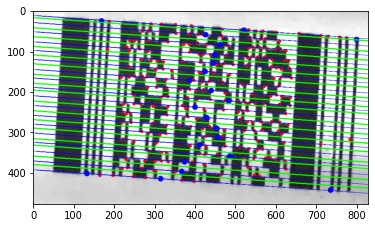

In [537]:
def debug_image(var_image, var_all_corners, var_barcode_corners, concur_feat_sep, line_prof_coor_arr):

    debug_img = copy.deepcopy(var_image)

    if not debug_img.ndim == 3:
        debug_img = np.stack((debug_img,) * 3, axis=-1)

    pt1_thickness, pt1_color = 4, (255, 0, 0)
    pt2_thickness, pt2_color = 7, (0, 0, 255)
    pt3_thickness, pt3_color = 7, (0, 0, 255)
    l1_thickness, l1_color = 1, (0, 0, 255)
    l2_thickness, l2_color = 1, (0, 255, 0)

    left_coord_arr = Int_prof_points[:, 0]
    right_coord_arr = Int_prof_points[:, 1]
    debug_img = overlay_corners(debug_img, var_all_corners, pt1_thickness, pt1_color)
    debug_img = overlay_corners(debug_img, var_barcode_corners, pt2_thickness, pt2_color)
    debug_img = overlay_corners(debug_img, concur_feat_sep, pt3_thickness, pt3_color)
    debug_img = overlay_lines(debug_img, line_prof_coor_arr[:, 0], line_prof_coor_arr[:, 1],
                                   l1_thickness, l1_color)
    debug_img = overlay_lines(debug_img, left_coord_arr, right_coord_arr, l2_thickness, l2_color)
    
    return debug_img


debug_image = debug_image(input_image, var_all_corners, var_barcode_corners, int_var_center_coord, line_prof_coor_arr)
plt.imshow(debug_image)

In [538]:
print(np.array(int_prof).shape, var_optim_threshold)

(51, 827) 0.25


In [539]:
def plot_int_profile(self):

    data = var_int_prof_arr
    fig_arr = []
    for i in range(len(data)):
        fig, ax = plt.subplots()
        for j in range(len(data[i])):
            elem_data = data[i][j]
            ax.plot(range(elem_data.shape[0]), elem_data, label='Line ' + str(j + 1))
        ax.legend()
        fig_arr.append(fig)
        
    return fig_arr

def plot_gradient(self):
    '''Visualization of height of each step'''

    x = np.arange(len(var_dist_grad))
    y = var_dist_grad
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(x, y)
    plt.title('Peaks Graph')
    
    return fig